In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import torch
from torch import nn, optim
import torch.utils.data as Data
from torch.nn import functional as F
from torch import distributions
import burst_detector as bd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
class Denoise(nn.Module):
    def __init__(self, n_filters, filter_sizes, spike_size):

        super(Denoise, self).__init__()
        
        feat1, feat2, feat3 = n_filters
        size1, size2, size3 = filter_sizes
        
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv1d(
                in_channels=1,              # input height
                out_channels=feat1,            # n_filters
                kernel_size=size1,              # filter size
                stride=1,                   # filter movement/step
                padding=0,                # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
        )

        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv1d(feat1, feat2, size2, 1, 0),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
        )

        self.conv3 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv1d(feat2, feat3, size3, 1, 0),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
        )

        #n_input_feat = feat3*(61-size1-size2-size3+3)
        n_input_feat = feat2*(spike_size-size1-size2+2)
        self.out = nn.Linear(n_input_feat, spike_size)
        
        #self.counter=0
        
    def forward(self, x):
        x = x[:, None]
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        #print (x.shape)
        #print (self.out(x).shape)
        #np.save('/home/cat/temp/'+str(self.counter)+'.npy', x.cpu().data.numpy())
        output = self.out(x)
        #self.counter+=1
        return output, x   # return x for visualization

    def train(self, fname_save, DenoTD, n_train=50000, n_test=500, EPOCH=2000, BATCH_SIZE=512, LR=0.0001):

        print('Training NN denoiser')

        if os.path.exists(fname_save):
            return

        optimizer = torch.optim.Adam(self.parameters(), lr=LR)   # optimize all cnn parameters
        loss_func = nn.MSELoss()                       # the target label is not one-hotted

        wf_col_train, wf_clean_train = DenoTD.make_training_data(n_train)
        train = Data.TensorDataset(torch.FloatTensor(wf_col_train), torch.FloatTensor(wf_clean_train))
        train_loader = Data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

        wf_col_test, wf_clean_test = DenoTD.make_training_data(n_test)

        # training and testing
        for epoch in range(EPOCH):
            for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
                est = self(b_x.cuda())[0]
                loss = loss_func(est, b_y.cuda())   # cross entropy loss
                optimizer.zero_grad()           # clear gradients for this training step
                loss.backward()                 # backpropagation, compute gradients
                optimizer.step()                # apply gradients

                if step % 100 == 0:
                    est_test = self(torch.FloatTensor(wf_col_test).cuda())[0]
                    l2_loss = np.mean(np.square(est_test.cpu().data.numpy() - wf_clean_test))
                    print('Epoch: ', epoch, '| train loss: %.4f' % loss.cpu().data.numpy(), '| test accuracy: %.4f' % l2_loss)
    
        # save model
        torch.save(self.state_dict(), fname_save)
                
    def load(self, fname_model):
        checkpoint = torch.load(fname_model,
                                map_location=lambda storage,
                                loc: storage)
        self.load_state_dict(checkpoint)
        del checkpoint
        torch.cuda.empty_cache()

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

In [222]:
model = torch.load("./denoise_NeuroPixels_30000Hz_3ms_40um.pt")

In [223]:
spike_size_nn = 61 ### In sample steps
n_filters_denoise = [16, 8, 4]
filter_sizes_denoise = [5, 11, 21]

In [224]:
denoiser = Denoise(n_filters_denoise,
                       filter_sizes_denoise,
                       spike_size_nn)

In [225]:
denoiser.load("./denoise_NeuroPixels_30000Hz_3ms_40um.pt")
denoiser = denoiser.to(device)

In [226]:
denoiser

Denoise(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(16, 8, kernel_size=(11,), stride=(1,))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(8, 4, kernel_size=(21,), stride=(1,))
    (1): ReLU()
  )
  (out): Linear(in_features=376, out_features=61, bias=True)
)

In [227]:
n_chan = 128
times = np.load('../data/midbrain_cullen/KS2.5_preprocessed/spike_times.npy').flatten().astype("int32")
clusters = np.load('../data/midbrain_cullen/KS2.5_preprocessed/spike_clusters.npy').flatten()
#mean_wf = np.load("../data/midbrain_cullen/KS2.5_preprocessed/mean_waveforms.npy")

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv("../data/midbrain_cullen/KS2.5_preprocessed/cluster_group.tsv", sep="\t")

In [228]:
# load raw data
rawData = np.memmap("../data/midbrain_cullen/NPX_001_Session_2_preprocessed.bin", dtype='int16', mode='r')
global data
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [285]:
ind = 4865# cluster 71
wf = np.zeros((1,61,384))
wf[:,:,:128]= data[times[ind]-30:times[ind]+31,:]
clusters[ind]

90

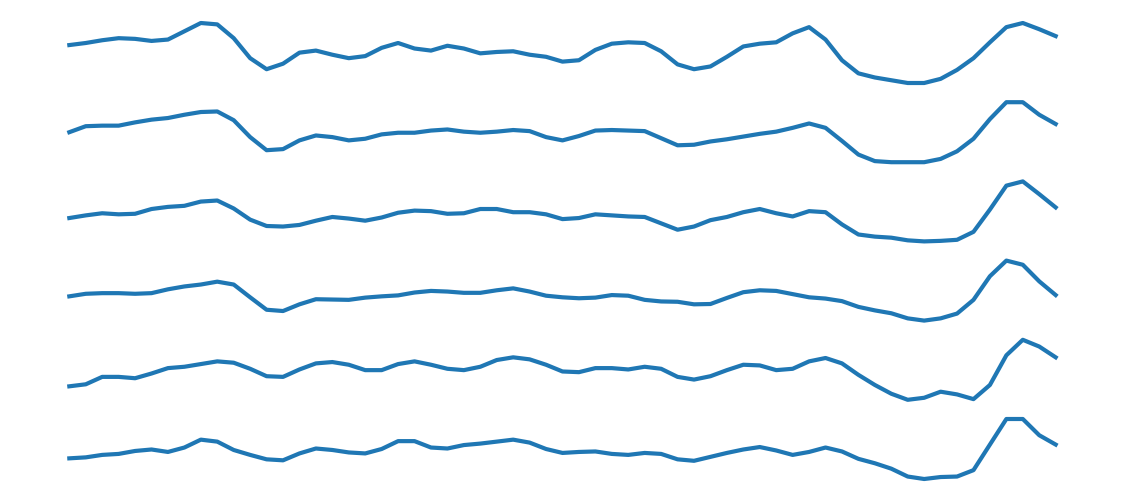

In [287]:
plt.figure(figsize=(7,3));
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.plot(wf[:,:,102+i].flatten());  plt.axis("off"); 
    # plt.ylim(-100, 100)

In [282]:
n_data, n_times, n_chans = wf.shape
wf_reshaped = wf.transpose(0, 2, 1).reshape(-1, n_times)
wf_torch = torch.FloatTensor(wf_reshaped).to(device)

In [283]:
denoised_wf = denoiser(wf_torch)[0].data
denoised_wf = denoised_wf.reshape(
                n_data, n_chans, n_times)
denoised_wf = denoised_wf.cpu().data.numpy().transpose(0, 2, 1)

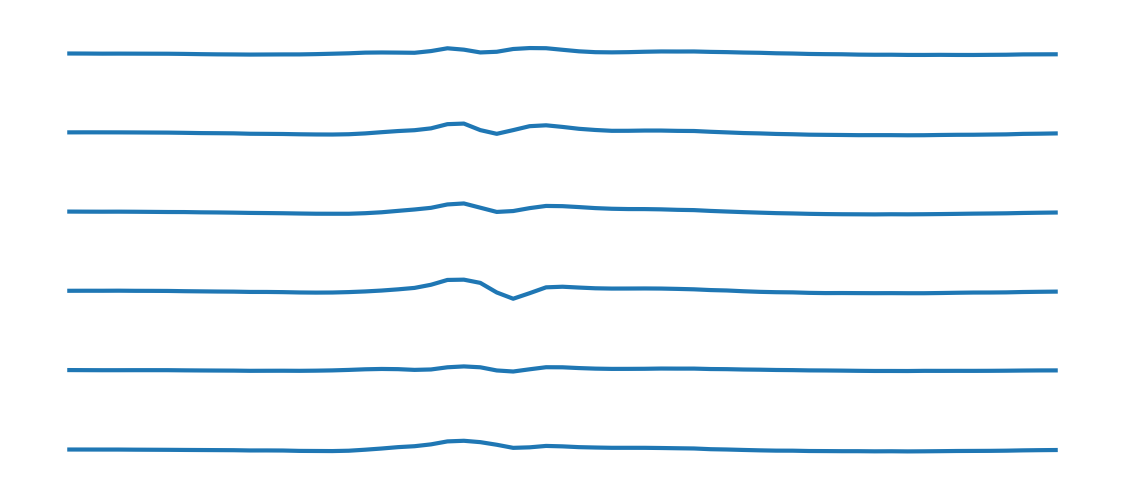

In [284]:
plt.figure(figsize=(7,3));
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.plot(denoised_wf[:,:,102+i].flatten());  plt.axis("off"); plt.ylim(-100, 100)